# **Import/Definicje**


In [232]:
import os
import cv2
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from torch import nn
from google.colab import drive
from skimage.feature import hog
from torchsummary import summary
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import load_img, img_to_array

In [233]:
drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/ASO/'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cpu


In [234]:
def draw_heatmap(image, preds, kernel, step):
  rows = preds.shape[0]
  cols = preds.shape[1]
  sy = kernel.shape[0]
  sx = kernel.shape[1]

  hmap = np.zeros(image.shape[2:])

  for r in range(rows):
    for c in range(cols):
      y = r * step
      x = c * step
      hmap[y:y + sy, x:x + sx] = hmap[y:y + sy, x:x + sx] + preds[r, c] * kernel

  if np.amax(hmap) > 1:
    hmap = hmap / np.amax(hmap)

  hmap2 = (hmap * 255).astype(np.uint8)

  cmap = cv2.applyColorMap(hmap2, cv2.COLORMAP_HOT)
  cmap = cmap[:, :, ::-1]
  img = (image.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
  ret = 0.3 * img + 0.7 * cmap


  return ret.astype(np.uint8)

In [235]:
def draw_overlay(img_arr, bboxes_list):
  overlay_thickness = 2
  font = cv2.FONT_HERSHEY_SIMPLEX

  for x in bboxes_list:
    start_point = (x[1][0] - x[1][2] // 2, x[1][1] - x[1][3] // 2)
    end_point = (x[1][0] + x[1][2] // 2, x[1][1] + x[1][3] // 2)
    text_start_point = (x[1][0] - x[1][2] // 2, x[1][1] - x[1][3] // 2 - 10)

    img_arr = cv2.rectangle(img_arr, start_point, end_point, 255, overlay_thickness)
    img_arr = cv2.putText(img_arr, x[0], text_start_point, font, 0.8, 255, overlay_thickness - 1, cv2.LINE_AA)

  plt.imshow(img_arr, cmap = 'gray')
  plt.axis('off')
  plt.show()

In [236]:
def IOU(bboxes1, bboxes2):
  x1A = bboxes1[0] - bboxes1[2] // 2
  y1A = bboxes1[1] - bboxes1[3] // 2
  x2A = bboxes1[0] + bboxes1[2] // 2
  y2A = bboxes1[1] + bboxes1[3] // 2

  x1B = bboxes2[0] - bboxes2[2] // 2
  y1B = bboxes2[1] - bboxes2[3] // 2
  x2B = bboxes2[0] + bboxes2[2] // 2
  y2B = bboxes2[1] + bboxes2[3] // 2

  xA = max(x1A, x1B)
  yA = max(y1A, y1B)
  xB = min(x2A, x2B)
  yB = min(y2A, y2B)

  intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

  box1_area = (x2A - x1A + 1) * (y2A - y1A + 1)
  box2_area = (x2B - x1B + 1) * (y2B - y1B + 1)

  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou

In [237]:
def IOU2(bboxes1, bboxes2):
  x1A = bboxes1[0] - bboxes1[2] // 2
  y1A = bboxes1[1] - bboxes1[3] // 2
  x2A = bboxes1[0] + bboxes1[2] // 2
  y2A = bboxes1[1] + bboxes1[3] // 2

  x1B = bboxes2[0]
  y1B = bboxes2[1]
  x2B = bboxes2[0] + bboxes2[2]
  y2B = bboxes2[1] + bboxes2[3]

  xA = max(x1A, x1B)
  yA = max(y1A, y1B)
  xB = min(x2A, x2B)
  yB = min(y2A, y2B)

  intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

  box1_area = (x2A - x1A + 1) * (y2A - y1A + 1)
  box2_area = (x2B - x1B + 1) * (y2B - y1B + 1)

  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou

In [335]:
def nms(bboxes_list, threshsold=0.2):
  final_boxes = []
  bboxes_sorted = sorted(bboxes_list, reverse=True, key=lambda x: x[2])

  while len(bboxes_sorted) > 0:
    box = bboxes_sorted.pop(0)

    for b in bboxes_sorted:
      if box[0] == b[0] and IOU(box[1], b[1]) >= threshsold: # box[0] == b[0] and
        bboxes_sorted.remove(b)

    final_boxes.append(box)

  return final_boxes

# **Nazwa pliku**

In [418]:
name = "Circuit_20.jpg"

# **Preprocessing**

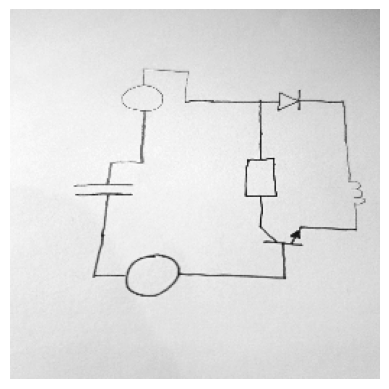

In [419]:
img_name = "TEST/"+name
#img_path = "/content/gdrive/MyDrive/gray.jpg"
img_path = data_dir + img_name
image_shapes = cv2.imread(img_path)
height, width, channels = image_shapes.shape
width_diff = width/256
height_diff = height/256
image = load_img(img_path, color_mode = "grayscale", target_size=(256, 256))
image = img_to_array(image).astype(np.float32) / 255.
plt.imshow(image[:,:, 0], cmap = 'gray')
plt.axis('off')
img = np.expand_dims(image, 0)

step = 4
sz = 64

xc = (img.shape[2] - sz) // step + 1
yc = (img.shape[1] - sz) // step + 1

hmap = np.zeros((yc, xc, 7))
img = torch.tensor(img).permute(0, 3, 1, 2)

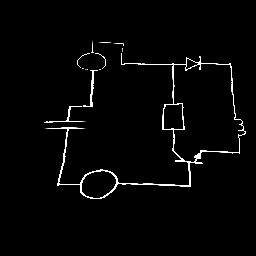

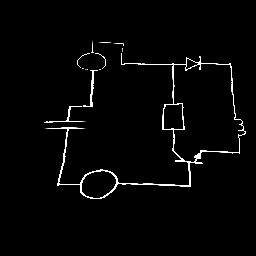

True

In [420]:
#img_name = "test.png"
#img_path = "/content/gdrive/MyDrive/gray.jpg"
#img_path = data_dir + img_name


# Tu ZMIENIAC
'''
im = cv2.resize(im, (512, 512))
gray = 255 - cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

_, bw = cv2.threshold(cv2.dilate(gray, None), 250, 255, cv2.THRESH_BINARY or cv2.THRESH_OTSU)
gray = cv2.bitwise_and(gray, bw)

for row in range(gray.shape[0]):
    avg = np.average(gray[row, :] > 16)
    if avg > 0.83:
        cv2.line(gray, (0, row), (gray.shape[1] - 1, row), (0, 0, 0), 1)

for col in range(gray.shape[1]):
    avg = np.average(gray[:, col] > 16)
    if avg > 0.77:
        cv2.line(gray, (col, 0), (col, gray.shape[0] - 1), (0, 0, 0), 1)

gray = cv2.fastNlMeansDenoising(gray, None,  10, 11, 21)
st = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 1))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, st, iterations=1)
st = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 7))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, st, iterations=1)
_, gray = cv2.threshold(gray,10, 255, cv2.THRESH_BINARY)

# PRZERWA
'''

img_name2 = "good256/"+name
#img_path = "/content/gdrive/MyDrive/gray.jpg"
img_path2 = data_dir + img_name2

gray = cv2.imread(img_path2)
# gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,69,9)

# for row in range(gray.shape[0]):
#     avg = np.average(gray[row, :] > 1)
#     if avg > 0.5:
#         cv2.line(gray, (0, row), (gray.shape[1] - 1, row), (0, 0, 0), 1)

# # Scan each column and remove vertical lines
# for col in range(gray.shape[1]):
#     avg = np.average(gray[:, col] > 1)
#     if avg > 0.4:
#         cv2.line(gray, (col, 0), (col, gray.shape[0] - 1), (0, 0, 0), 1)

gray = cv2.fastNlMeansDenoising(gray, None,  27, 11, 23)

# DOTAD ZMIENIAC

cv2_imshow(gray)

#cv2.imshow("im", im)
#gray = cv2.resize(gray, (512, 512))
cv2_imshow(gray)
gray_path = img_path[:-4] + '_gray.jpg'
cv2.imwrite(gray_path, gray)

#gray = torch.tensor(gray).permute(0, 1)


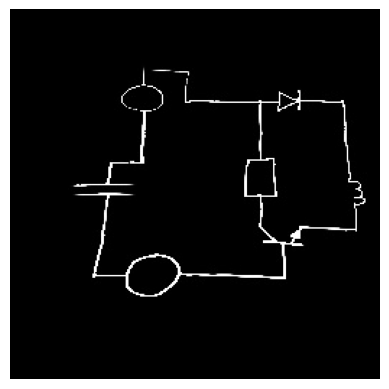

In [421]:
#img_name = "gray2.jpg"
#img_path = "/content/gdrive/MyDrive/gray.jpg"
#img_path = data_dir + img_name

#gray_path = "/content/gdrive/MyDrive/ASO/good256/18_1_resized.jpg"
# img_path = gray_path


image = load_img(gray_path, color_mode = "grayscale", target_size=(256, 256))
image = img_to_array(image).astype(np.float32) / 255.
plt.imshow(image[:,:, 0], cmap = 'gray')
plt.axis('off')
img = np.expand_dims(image, 0)

image_shapes = cv2.imread(img_path)
height, width, channels = image_shapes.shape
width_diff = width/256
height_diff = height/256

step = 2
sz = 64
ish1 = img.shape[1]
ish2 = img.shape[2]
xc = (img.shape[2] - sz) // step + 1
yc = (img.shape[1] - sz) // step + 1

hmap = np.zeros((yc, xc, 7))
img = torch.tensor(img).permute(0, 3, 1, 2)

#**CNN**

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.batch2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act2 = nn.ReLU()

    self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.batch3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act3 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(4, 4))

    self.flat = nn.Flatten()

    self.lin1 = nn.Linear(256, 64)
    self.act4 = nn.ReLU()

    self.lin2 = nn.Linear(64, 7)
    self.act5 = nn.Softmax()


  def forward(self, x):
    x = self.act1(self.batch1(self.conv1(x)))
    x = self.act2(self.batch2(self.conv2(x)))
    x = self.act3(self.batch3(self.conv3(x)))
    x = self.pool(x)
    x = self.flat(x)
    x = self.act4(self.lin1(x))
    x = self.act5(self.lin2(x))

    return x

In [ ]:
cnn_weights_name = "cnn"
cnn_weights_path = data_dir+cnn_weights_name
#cnn_weights = torch.load('/content/gdrive/MyDrive/test')
#cnn_weights = torch.load(cnn_weights_path)
cnn_weights = torch.load(cnn_weights_path, map_location='cpu')
cnn = ConvNet()
cnn.load_state_dict(cnn_weights)

v = (1, 32, 32)
summary(cnn, input_size=v)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,088
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4            [-1, 128, 8, 8]         131,072
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         524,288
       BatchNorm2d-8            [-1, 256, 4, 4]             512
              ReLU-9            [-1, 256, 4, 4]               0
        MaxPool2d-10            [-1, 256, 1, 1]               0
          Flatten-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
confidence = 0.95
bboxes = []
lbl_map = {0: 'C', 1: 'D', 2: 'L', 3: 'R', 4: 'S', 5: 'T', 6: 'B'}

for x in range(xc):
  for y in range(yc):
    crop = img[:, :, y * step:y * step + sz, x * step:x * step + sz]

    #CNN
    scores = cnn(crop).detach().numpy()
    hmap[y, x, :] = scores
    if max(scores[0]) > confidence:
      max_idx = np.argmax(scores[0])
      bboxes.append((lbl_map[max_idx], [x * step + sz // 2, y * step + sz // 2, sz, sz], scores[0][max_idx]))

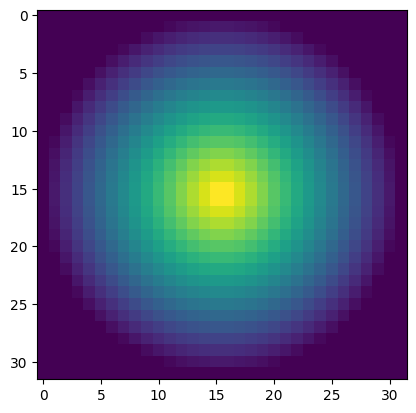

In [ ]:
x_axis = np.linspace(-1, 1, sz)[:, None]
y_axis = np.linspace(-1, 1, sz)[None, :]

arr = 1 - np.sqrt(x_axis ** 2 + y_axis ** 2)
arr[arr<0] = 0
plt.imshow(arr)

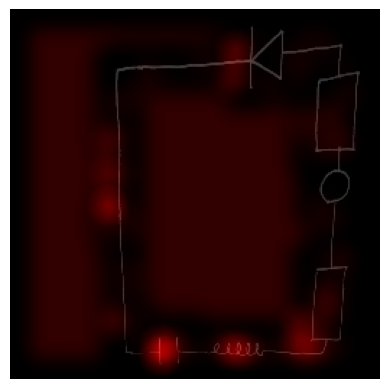

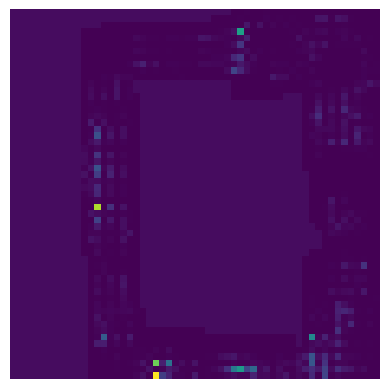

In [ ]:
idx = 1
plt.imshow(draw_heatmap(img, hmap[:, :, idx], arr, step))
plt.axis('off')
plt.show()
plt.imshow(hmap[:, :, idx])
plt.axis('off')
plt.show()

In [ ]:
txtfile = "18_1_resized.txt"
f = open((data_dir + txtfile), 'r')
f_data = []

for line in f:
  f_data.append(line.split(','))

f.close()
f_data = [[x[0], int(x[1]), int(x[2]), int(x[3]), int(x[4]), int(x[5])] for x in f_data]
ground_truth = [[x[2], x[3], x[4], x[5]] for x in f_data]
print(ground_truth)

[[967, 58, 154, 299], [591, 1306, 113, 160], [1237, 264, 182, 326], [1226, 1026, 149, 340], [1242, 639, 155, 165], [812, 1328, 239, 112]]


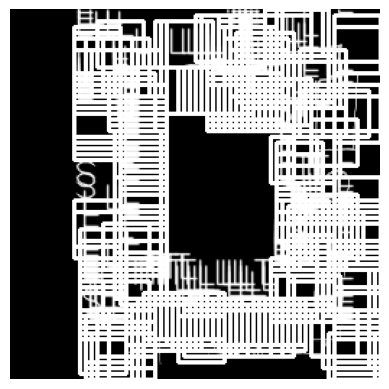

In [ ]:
draw_overlay((image * 255).astype(np.uint8), bboxes)

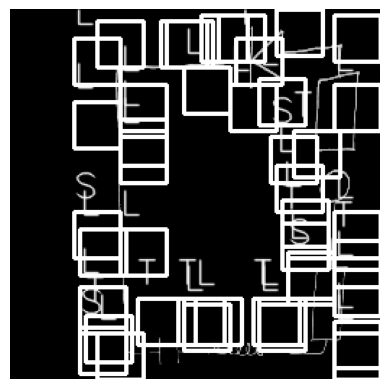

In [ ]:
final = nms(bboxes, threshsold=0.01)
draw_overlay((image * 255).astype(np.uint8), final)

# **SVM**

In [422]:
svm_model ="v12.pkl"
svm_path = data_dir+svm_model

with open(svm_path, 'rb') as f:
    svm = pickle.load(f)
    f.close()

svm_model2 ="model_thin.pkl"
svm_path2 = data_dir+svm_model2

with open(svm_path2, 'rb') as f:
    svm2 = pickle.load(f)
    f.close()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [423]:
confidence = 0.95
confidence2 = 0.79

bboxes = []
lbl_map = {0: 'C', 1: 'D', 2: 'L', 3: 'R', 4: 'S', 5: 'T', 6: 'B'}
for x in range(xc):
  for y in range(yc):
    crop = img[:, :, y * step:y * step + sz, x * step:x * step + sz]

    # SVM
    fd = hog(crop.squeeze(), 9, (8, 8), (2, 2), block_norm='L2', feature_vector=True)
    scores = svm.decision_function(fd.reshape(1, -1))
    pred = svm.predict(fd.reshape(1, -1))
    scores = np.exp(scores) / np.sum(np.exp(scores), axis=1)
    hmap[y, x, :] = scores

    scores2 = svm2.decision_function(fd.reshape(1, -1))
    pred2 = svm2.predict(fd.reshape(1, -1))
    scores2 = np.exp(scores2) / np.sum(np.exp(scores2), axis=1)
    hmap[y, x, :] = scores2

    if max(scores[0]) > confidence and pred[0] != 'B':
      bboxes.append((svm.predict(fd.reshape(1, -1))[0],
                    [x * step + sz // 2, y * step + sz // 2, sz, sz],
                     scores[0][np.argmax(scores[0])]))
    if max(scores2[0]) > confidence2 and pred2[0] != 'B':
      bboxes.append((svm2.predict(fd.reshape(1, -1))[0],
                    [x * step + sz // 2, y * step + sz // 2, sz, sz],
                     scores2[0][np.argmax(scores2[0])]))

In [424]:
confidence = 0.95
confidence2 = 0.79
sz = 32
xc = (ish2 - sz) // step + 1
yc = (ish1 - sz) // step + 1
hmap = np.zeros((yc, xc, 7))
for x in range(xc):
  for y in range(yc):
    crop = img[:, :, y * step:y * step + sz, x * step:x * step + sz]

    # SVM
    fd = hog(crop.squeeze(), 9, (4, 4), (2, 2), block_norm='L2', feature_vector=True)
    scores = svm.decision_function(fd.reshape(1, -1))
    pred = svm.predict(fd.reshape(1, -1))
    scores = np.exp(scores) / np.sum(np.exp(scores), axis=1)
    hmap[y, x, :] = scores

    scores2 = svm2.decision_function(fd.reshape(1, -1))
    pred2 = svm2.predict(fd.reshape(1, -1))
    scores2 = np.exp(scores2) / np.sum(np.exp(scores2), axis=1)
    hmap[y, x, :] = scores2

    if max(scores[0]) > confidence and pred[0] != 'B':
      bboxes.append((svm.predict(fd.reshape(1, -1))[0],
                    [x * step + sz // 2, y * step + sz // 2, sz, sz],
                     scores[0][np.argmax(scores[0])]))
    if max(scores2[0]) > confidence2 and pred2[0] != 'B':
      bboxes.append((svm2.predict(fd.reshape(1, -1))[0],
                    [x * step + sz // 2, y * step + sz // 2, sz, sz],
                     scores2[0][np.argmax(scores2[0])]))

WYNIKI

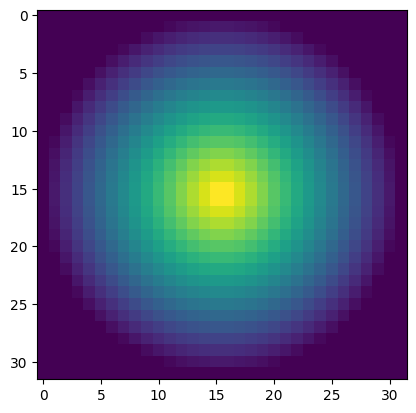

In [425]:
x_axis = np.linspace(-1, 1, sz)[:, None]
y_axis = np.linspace(-1, 1, sz)[None, :]

arr = 1 - np.sqrt(x_axis ** 2 + y_axis ** 2)
arr[arr<0] = 0
plt.imshow(arr)

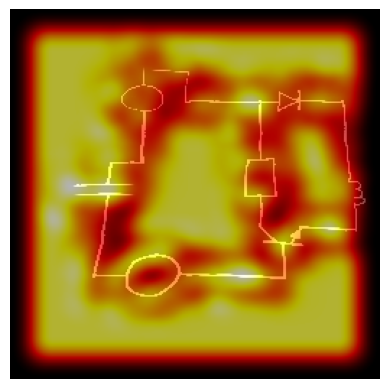

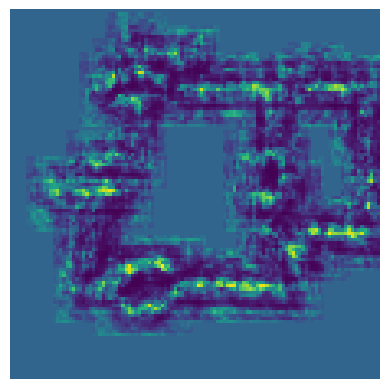

In [426]:
idx = 1
plt.imshow(draw_heatmap(img, hmap[:, :, idx], arr, step))
plt.axis('off')
plt.show()
plt.imshow(hmap[:, :, idx])
plt.axis('off')
plt.show()

In [427]:
txtfile = img_path[:-3] + 'txt'
f = open(txtfile, 'r')
f_data = []

for line in f:
  f_data.append(line.split(','))

f.close()
f_data = [(x[0], [int(x[2]), int(x[3]), int(x[4]), int(x[5])]) for x in f_data]
#ground_truth = [[x[2], x[3], x[4], x[5]] for x in f_data]
print(f_data)
#print(ground_truth)

[('S', [287, 190, 138, 111]), ('S', [306, 642, 164, 153]), ('L', [893, 440, 66, 104]), ('T', [634, 568, 195, 89]), ('R', [150, 448, 209, 83]), ('R', [617, 377, 131, 142]), ('D', [713, 199, 92, 85]), ('C', [146, 429, 219, 105])]


In [428]:
print(bboxes)

[('R', [50, 130, 64, 64], 0.8371842657174282), ('C', [64, 122, 64, 64], 0.7916652047610112), ('R', [78, 98, 64, 64], 0.8277338157933739), ('R', [78, 102, 64, 64], 0.8124133987724994), ('R', [78, 104, 64, 64], 0.8502741235467122), ('R', [82, 64, 64, 64], 0.7986937885726935), ('R', [82, 76, 64, 64], 0.8061895812194397), ('S', [90, 64, 64, 64], 0.9603704385880101), ('S', [96, 182, 64, 64], 0.960042445535809), ('S', [98, 182, 64, 64], 0.9665020892552453), ('R', [102, 186, 64, 64], 0.9507193777801533), ('R', [104, 186, 64, 64], 0.9911540517858102), ('R', [104, 188, 64, 64], 0.9891055744918829), ('R', [106, 186, 64, 64], 0.9865608638978149), ('R', [106, 188, 64, 64], 0.9778631979587281), ('R', [108, 186, 64, 64], 0.9572068009743374), ('C', [118, 180, 64, 64], 0.8226894798964988), ('L', [124, 46, 64, 64], 0.8191728917221499), ('L', [126, 44, 64, 64], 0.799165234223491), ('L', [126, 46, 64, 64], 0.8476493692544219), ('C', [164, 64, 64, 64], 0.8081906364268903), ('C', [166, 58, 64, 64], 0.81644

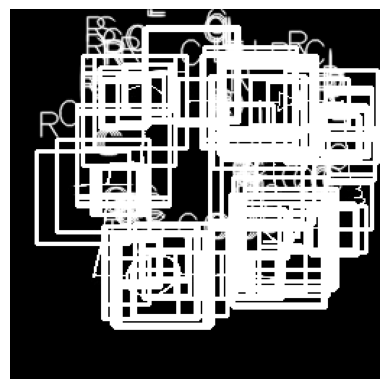

In [429]:
draw_overlay((image * 255).astype(np.uint8), bboxes)

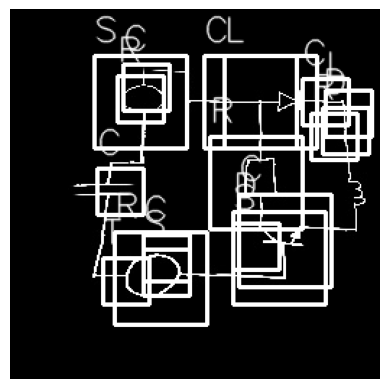

In [430]:
final = nms(bboxes, threshsold=0.001)
final = nms(final, threshsold=0.01)
draw_overlay((image * 255).astype(np.uint8), final)

## Tu dodane te recalle precision itd

In [431]:
print(final)
print(f_data)

[('R', [104, 186, 64, 64], 0.9911540517858102), ('L', [180, 64, 64, 64], 0.9870260745043992), ('R', [90, 62, 32, 32], 0.9753004339568443), ('L', [234, 72, 32, 32], 0.9751545760728471), ('S', [108, 182, 32, 32], 0.9682470802620764), ('R', [224, 88, 32, 32], 0.9633624459294275), ('S', [90, 64, 64, 64], 0.9603704385880101), ('T', [80, 188, 32, 32], 0.9582863292862579), ('D', [232, 84, 32, 32], 0.929172008307628), ('R', [170, 120, 64, 64], 0.92662687418168), ('C', [190, 160, 64, 64], 0.9224679227855683), ('C', [108, 172, 32, 32], 0.9003909392563265), ('D', [186, 172, 64, 64], 0.8747305236059221), ('C', [76, 126, 32, 32], 0.8732356974895131), ('C', [166, 64, 64, 64], 0.8510135980637813), ('C', [94, 54, 32, 32], 0.8436236656468691), ('C', [218, 64, 32, 32], 0.8259886582510647), ('S', [170, 164, 32, 32], 0.8152269011361484)]
[('S', [287, 190, 138, 111]), ('S', [306, 642, 164, 153]), ('L', [893, 440, 66, 104]), ('T', [634, 568, 195, 89]), ('R', [150, 448, 209, 83]), ('R', [617, 377, 131, 142])

In [432]:
PR_list = []
correct_boxes = []

def recall_precision(bboxes_list, ground_truth_list, threshsold=0.1):
  bboxes_sorted = sorted(bboxes_list, reverse=True, key=lambda x: x[2])
  #print(bboxes_sorted)
  ground_list = ground_truth_list
  for gr in ground_list:
    gr[1][0] = gr[1][0] // width_diff
    gr[1][1] = gr[1][1] // height_diff
    gr[1][2] = gr[1][2] // width_diff
    gr[1][3] = gr[1][3] // height_diff
  recall_count = 0

  while len(bboxes_sorted) > 0:
    box = bboxes_sorted.pop(0)
    correct = False

    for g in ground_list:
      if box[0] == g[0] and IOU2(box[1], g[1]) >= threshsold:
        recall_count = recall_count + 1
        correct = True
        break

    current_precision = recall_count / (len(PR_list)+1)
    current_recall = recall_count / len(f_data)
    PR_list.append([current_precision, current_recall])
    correct_boxes.append((box, correct))
  recall_score = recall_count/len(f_data)
  precision_score = recall_count/len(final)
  return recall_count, recall_score, precision_score, PR_list

In [433]:
recall_count, recall_score, precision_score, PR_list = recall_precision(final, f_data, 0.2)
print('recall = ', recall_score)
print('precision = ', precision_score)

recall =  0.5
precision =  0.2222222222222222


In [434]:
print(PR_list)

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.2, 0.125], [0.16666666666666666, 0.125], [0.2857142857142857, 0.25], [0.25, 0.25], [0.2222222222222222, 0.25], [0.3, 0.375], [0.2727272727272727, 0.375], [0.25, 0.375], [0.23076923076923078, 0.375], [0.2857142857142857, 0.5], [0.26666666666666666, 0.5], [0.25, 0.5], [0.23529411764705882, 0.5], [0.2222222222222222, 0.5]]


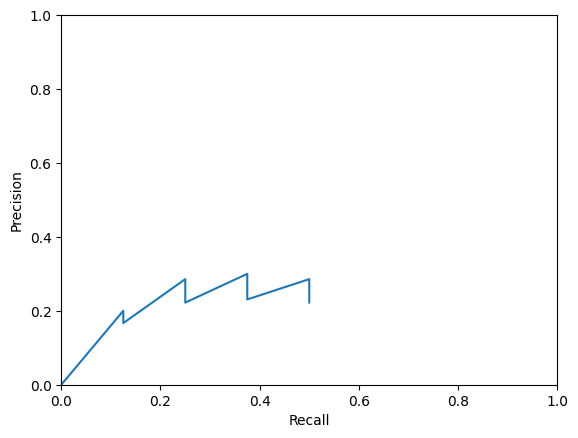

In [435]:
ax = plt.gca()
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])

x_elem = []
y_elem = []
for elem in PR_list:
  x_elem.append(elem[1])
  y_elem.append(elem[0])

plt.plot(x_elem, y_elem)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [436]:
def mAP(PR_list):
  precision = 0
  for elem in PR_list:
    precision = precision + elem[0]
  return precision / len(PR_list)

In [437]:
print(mAP(PR_list))

0.1909998316861062


In [438]:
print(final)

[('R', [104, 186, 64, 64], 0.9911540517858102), ('L', [180, 64, 64, 64], 0.9870260745043992), ('R', [90, 62, 32, 32], 0.9753004339568443), ('L', [234, 72, 32, 32], 0.9751545760728471), ('S', [108, 182, 32, 32], 0.9682470802620764), ('R', [224, 88, 32, 32], 0.9633624459294275), ('S', [90, 64, 64, 64], 0.9603704385880101), ('T', [80, 188, 32, 32], 0.9582863292862579), ('D', [232, 84, 32, 32], 0.929172008307628), ('R', [170, 120, 64, 64], 0.92662687418168), ('C', [190, 160, 64, 64], 0.9224679227855683), ('C', [108, 172, 32, 32], 0.9003909392563265), ('D', [186, 172, 64, 64], 0.8747305236059221), ('C', [76, 126, 32, 32], 0.8732356974895131), ('C', [166, 64, 64, 64], 0.8510135980637813), ('C', [94, 54, 32, 32], 0.8436236656468691), ('C', [218, 64, 32, 32], 0.8259886582510647), ('S', [170, 164, 32, 32], 0.8152269011361484)]


In [439]:
scaled_boxes = []

for elem in final:
  scaled_boxes.append((elem[0], [round(elem[1][0] * width_diff), round(elem[1][1] * height_diff), round(elem[1][2] * width_diff), round(elem[1][3] * height_diff)]))
print(scaled_boxes)
out_path = img_path[:-4] + '_results.txt'
f = open(out_path, "w")
new_format = [','.join((sb[0], str(sb[1][0]), str(sb[1][1]), str(sb[1][2]), str(sb[1][3]))) for sb in scaled_boxes]

for x in new_format:
  f.write(x)
  f.write('\n')

f.close()

[('R', [406, 727, 250, 250]), ('L', [703, 250, 250, 250]), ('R', [352, 242, 125, 125]), ('L', [914, 281, 125, 125]), ('S', [422, 711, 125, 125]), ('R', [875, 344, 125, 125]), ('S', [352, 250, 250, 250]), ('T', [312, 734, 125, 125]), ('D', [906, 328, 125, 125]), ('R', [664, 469, 250, 250]), ('C', [742, 625, 250, 250]), ('C', [422, 672, 125, 125]), ('D', [727, 672, 250, 250]), ('C', [297, 492, 125, 125]), ('C', [648, 250, 250, 250]), ('C', [367, 211, 125, 125]), ('C', [852, 250, 125, 125]), ('S', [664, 641, 125, 125])]


In [440]:
print(correct_boxes)

[(('R', [104, 186, 64, 64], 0.9911540517858102), False), (('L', [180, 64, 64, 64], 0.9870260745043992), False), (('R', [90, 62, 32, 32], 0.9753004339568443), False), (('L', [234, 72, 32, 32], 0.9751545760728471), False), (('S', [108, 182, 32, 32], 0.9682470802620764), True), (('R', [224, 88, 32, 32], 0.9633624459294275), False), (('S', [90, 64, 64, 64], 0.9603704385880101), True), (('T', [80, 188, 32, 32], 0.9582863292862579), False), (('D', [232, 84, 32, 32], 0.929172008307628), False), (('R', [170, 120, 64, 64], 0.92662687418168), True), (('C', [190, 160, 64, 64], 0.9224679227855683), False), (('C', [108, 172, 32, 32], 0.9003909392563265), False), (('D', [186, 172, 64, 64], 0.8747305236059221), False), (('C', [76, 126, 32, 32], 0.8732356974895131), True), (('C', [166, 64, 64, 64], 0.8510135980637813), False), (('C', [94, 54, 32, 32], 0.8436236656468691), False), (('C', [218, 64, 32, 32], 0.8259886582510647), False), (('S', [170, 164, 32, 32], 0.8152269011361484), False)]


In [441]:
def draw_final(img_arr, g_truth, results):
  overlay_thickness = 5
  font = cv2.FONT_HERSHEY_SIMPLEX

  for x in g_truth:
    '''
    start_point = (int((x[1][0] - x[1][2] //2) * width_diff) , int((x[1][1] - x[1][3] //2) *height_diff) )
    end_point = (int((x[1][0] + x[1][2]//2) * width_diff) , int((x[1][1] + x[1][3]//2) * height_diff) )
    text_start_point = (int((x[1][0] - x[1][2]//2) * width_diff) , int((x[1][1] - x[1][3]//2) * height_diff) - 10)
'''
    start_point = (int(x[1][0] * width_diff) , int(x[1][1]*height_diff))
    end_point = (int((x[1][0] + x[1][2]) * width_diff) , int((x[1][1] + x[1][3]) * height_diff) )
    text_start_point = (int((x[1][0]) * width_diff) , int((x[1][1]) * height_diff) - 10)

    img_arr = cv2.rectangle(img_arr, start_point, end_point, (255, 255, 255), overlay_thickness)
    img_arr = cv2.putText(img_arr, x[0], text_start_point, font, 2.0, (255, 255, 255), overlay_thickness - 1,   cv2.LINE_AA)

  for x in results:
    start_point = (int((x[0][1][0] - x[0][1][2]//2) * width_diff), int((x[0][1][1] - x[0][1][3]//2) * height_diff))
    end_point = (int((x[0][1][0] + x[0][1][2]//2) *width_diff), int((x[0][1][1] + x[0][1][3]//2) *height_diff))
    text_start_point = (int((x[0][1][0] - x[0][1][2]//2) *width_diff), int((x[0][1][1] - x[0][1][3]//2) *height_diff) - 10)
    if x[1] is True:
      rect_color = (0, 255, 0)
    else:
      rect_color = (255, 0, 0)
    img_arr = cv2.rectangle(img_arr, start_point, end_point, rect_color, overlay_thickness)
    img_arr = cv2.putText(img_arr, x[0][0], text_start_point, font, 2.0, rect_color, overlay_thickness - 1,  cv2.LINE_AA)

  cv2.imwrite(data_dir+img_name[:-4]+'result.jpg', cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR))

  plt.imshow(img_arr, cmap = 'gray')
  plt.axis('off')
  plt.show()

# **Final**

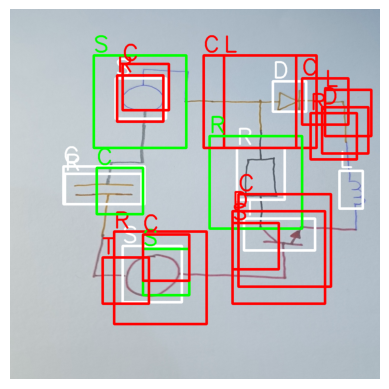

recall =  0.5
precision =  0.2222222222222222


True

In [442]:
final_image = cv2.imread(img_path)

draw_final(final_image, f_data, correct_boxes)
print('recall = ', recall_score)
print('precision = ', precision_score)

cv2.imwrite(name[0: len(name)-4]+"svm_v12.jpg", cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))